--- 
# Part 2: More Data Preprocessing, Merging Datasets & RFM Metrics

This notebook includes more data preprocessing, steps taken to aggregate and merge the datasets, as well as RFM (Recency, Frequency, and Monetary) Scores calculated from the data.

--- 

# Contents

- [Merge Portfolio & Offers](#Merge-Portfolio-&-Offers)
- [Split Offer Events](#Merge-Portfolio-&-Offers)
- [Calculate Offer Engagement](#Calculate-Offer-Engagement)
- [Aggregation of Different Columns and Dataframes](#Aggregation-of-Different-Columns-and-Dataframes)
- [RFM Metrics](#RFM-Metrics)
- [Save Final Cleaned & Aggregated File](#Save-Final-Cleaned-&-Aggregated-File)

# References
1. https://www.kaggle.com/regivm/rfm-analysis-tutorial
2. Data Preprocessing Functions: https://github.com/alghsaleh/starbucks-customers-segmentation/blob/master/utilities.py
3. https://medium.com/capillary-data-science/rfm-analysis-an-effective-customer-segmentation-technique-using-python-58804480d232

# Importing Libraries

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import re
import calendar
import ast
    
pd.set_option('display.max_rows', None)
sns.set_palette('Greens_r')

# Re-Import Cleaned Data

In [3]:
transactions = pd.read_csv('../data/transactions_clean.csv')
offers = pd.read_csv('../data/offers_clean.csv')
portfolio = pd.read_csv('../data/portfolio_clean.csv')
profile = pd.read_csv('../data/profile_clean.csv')

transactions.head(3)

,customer_id,amount,time
0,41,0.83,0
1,55,34.56,0
2,63,13.23,0


In [4]:
offers.head(3)

,customer_id,event,offer_id,time
0,3,offer received,4,0
1,4,offer received,5,0
2,5,offer received,10,0


In [5]:
portfolio.head(3)

,reward,difficulty,duration,offer_id,email,mobile,web,social,bogo,discount,informational
0,10,10,7,1,1,1,0,1,1,0,0
1,10,10,5,2,1,1,1,1,1,0,0
2,0,0,4,3,1,1,1,0,0,0,1


In [6]:
profile.head(3)

,customer_id,membership_days,age,income,gender_Blank,gender_F,gender_M,gender_O
0,0,530,61,99000,1,0,0,0
1,1,377,55,112000,0,1,0,0
2,2,15,56,39000,1,0,0,0


# More Data Preprocessing
Merge dataframes so that we have each customer with all of their personal demographics, transactional aggregates, and promotional aggregates. 

In [7]:
transactions.shape, offers.shape, portfolio.shape, profile.shape

((138953, 3), (167581, 4), (10, 11), (17000, 8))

In [8]:
print(f'Transaction Columns: {transactions.columns}')
print(f'Offer Columns: {transactions.columns}')
print(f'Portfolio Columns: {portfolio.columns}')
print(f'Profile Columns: {profile.columns}')

Transaction Columns: Index(['customer_id', 'amount', 'time'], dtype='object')
Offer Columns: Index(['customer_id', 'amount', 'time'], dtype='object')
Portfolio Columns: Index(['reward', 'difficulty', 'duration', 'offer_id', 'email', 'mobile',
       'web', 'social', 'bogo', 'discount', 'informational'],
      dtype='object')
Profile Columns: Index(['customer_id', 'membership_days', 'age', 'income', 'gender_Blank',
       'gender_F', 'gender_M', 'gender_O'],
      dtype='object')


## Merge Portfolio & Offers

In [9]:
offers = pd.merge(offers, portfolio, on='offer_id')
offers.head()

,customer_id,event,offer_id,time,reward,difficulty,duration,email,mobile,web,social,bogo,discount,informational
0,3,offer received,4,0,5,5,7,1,1,1,0,1,0,0
1,29,offer received,4,0,5,5,7,1,1,1,0,1,0,0
2,34,offer received,4,0,5,5,7,1,1,1,0,1,0,0
3,42,offer received,4,0,5,5,7,1,1,1,0,1,0,0
4,47,offer received,4,0,5,5,7,1,1,1,0,1,0,0


In [10]:
offers.shape

(167581, 14)

## Split Offers Based on Events

In [11]:
received = offers[offers['event'] == 'offer received']
viewed = offers[offers['event'] == 'offer viewed']
completed = offers[offers['event'] == 'offer completed']

In [12]:
# Make a copy of received for aggregations
offers_agg = received.copy()
offers_agg.head(3)

,customer_id,event,offer_id,time,reward,difficulty,duration,email,mobile,web,social,bogo,discount,informational
0,3,offer received,4,0,5,5,7,1,1,1,0,1,0,0
1,29,offer received,4,0,5,5,7,1,1,1,0,1,0,0
2,34,offer received,4,0,5,5,7,1,1,1,0,1,0,0


In [13]:
# Dummifying event['offer received']
offers_agg = offers_agg.rename(columns={'event': 'offer_received'})
offers_agg['offer_received'] = 1

In [14]:
# Calculate 'offer_end_time' with 'time' (hour) of the offer released and 'duration' in days converted to hours
offers_agg = offers_agg.rename(columns={'time': 'offer_start_time'})
offers_agg['offer_end_time'] = offers_agg['offer_start_time'] + offers_agg['duration'] * 24
offers_agg.head()

,customer_id,offer_received,offer_id,offer_start_time,reward,difficulty,duration,email,mobile,web,social,bogo,discount,informational,offer_end_time
0,3,1,4,0,5,5,7,1,1,1,0,1,0,0,168
1,29,1,4,0,5,5,7,1,1,1,0,1,0,0,168
2,34,1,4,0,5,5,7,1,1,1,0,1,0,0,168
3,42,1,4,0,5,5,7,1,1,1,0,1,0,0,168
4,47,1,4,0,5,5,7,1,1,1,0,1,0,0,168


## Calculate Offer Engagement

In [15]:
def get_offer_engagements(offers_agg, viewed, completed, transactions):

    # Save parameters from offers_agg as variables
    customer_id = offers_agg['customer_id']
    offer_id = offers_agg['offer_id']
    offer_start_time = offers_agg['offer_start_time']
    offer_end_time = offers_agg['offer_end_time']

    # Get view time from 'viewed'
    viewed_time_list = viewed.loc[
        # Lookup the identified record
        (viewed['customer_id'] == customer_id) & (viewed['offer_id'] == offer_id) &
        # Assess view time is in duration
        (viewed['time'] >= offer_start_time) & (viewed['time'] <= offer_end_time)]['time'].tolist()

    # Store view time if available in list else return NaN
    offer_viewed_time = np.NaN if not viewed_time_list else viewed_time_list[0]

    # Get offer_completed_time
    # Get 'time' from 'completed' if offer is bogo or discount
    if offers_agg['informational'] == 0:
        completed_time_list = completed.loc[
            # Lookup the identified record
            (completed['customer_id'] == customer_id) & (completed['offer_id'] == offer_id) &
            # Assess completion time is after view and in duration
            (completed['time'] >= offer_viewed_time) & (completed['time'] <= offer_end_time )]['time'].tolist()

    # Get 'time' from 'transactions' if offer is informational
    if offers_agg['informational'] == 1:
        # Get 'time' for all customer transactions
        customer_transactions = transactions.loc[(transactions['customer_id'] == customer_id)]['time'].tolist()

        # Instantiate list
        completed_time_list = []

        for transaction_time in customer_transactions:
            # Assess transaction time is after view and in duration
            if ((transaction_time >= offer_viewed_time) & (transaction_time <= offer_end_time)):
                completed_time_list.append(transaction_time)

    # Store completion time if available in list else return NaN
    offer_completed_time = np.NaN if not completed_time_list else completed_time_list[0]

    # Create return object
    output_value = [offer_viewed_time, offer_completed_time]

    return output_value

In [16]:
def expand_list_to_columns(df, target_column, column_labels):

    # Split list elements into columns and merge back to original dataframe
    df = df[target_column].apply(pd.Series).merge(df, left_index=True, right_index=True)

    # Rename columns as per 'column_labels'
    df = df.rename(columns=column_labels)

    # Drop 'target_column'
    df = df.drop(columns=target_column)

    return df

In [17]:
# Add empty object column to store 'output_value' list
offers_agg['output_value'] = ''

# Apply get_offer_engagements to each row
offers_agg.output_value = offers_agg.apply(
    lambda x: get_offer_engagements(x, viewed, completed, transactions), axis=1)

# Expand 'output_value' list to columns
offers_agg = expand_list_to_columns(offers_agg, 'output_value', {
    0: 'offer_viewed_time',
    1: 'offer_completed_time'})

In [18]:
offers_agg[['offer_start_time', 'offer_end_time', 'offer_viewed_time', 'offer_completed_time']].head()

,offer_start_time,offer_end_time,offer_viewed_time,offer_completed_time
0,0,168,6.0,132.0
1,0,168,NaN,NaN
2,0,168,48.0,NaN
3,0,168,30.0,66.0
4,0,168,NaN,NaN


In [19]:
# Add 'response_score' column

offers_agg['response_score'] = (offers_agg['offer_completed_time'] -
    offers_agg['offer_viewed_time']).apply(lambda x: x if x >= 0 else np.NaN)

offers_agg['response_score'] = np.round(((
    (offers_agg['duration'] * 24) - offers_agg['response_score']) /
    (offers_agg['duration'] * 24)), 2).fillna(0) 

offers_agg[['offer_viewed_time', 'offer_completed_time', 'response_score']].head()

,offer_viewed_time,offer_completed_time,response_score
0,6.0,132.0,0.25
1,NaN,NaN,0.00
2,48.0,NaN,0.00
3,30.0,66.0,0.79
4,NaN,NaN,0.00


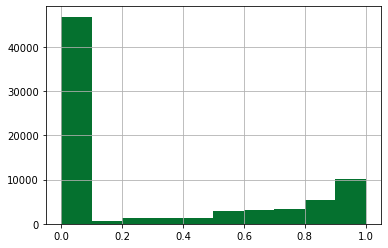

In [20]:
offers_agg['response_score'].hist();

In [21]:
# Add 'offer_viewed' and 'offer_completed' columns that are dummified
offers_agg['offer_viewed'] = offers_agg['offer_viewed_time'].apply(lambda x: 0 if pd.isnull(x) else 1)
offers_agg['offer_completed'] = offers_agg['offer_completed_time'].apply(lambda x: 0 if pd.isnull(x) else 1)
offers_agg[['offer_viewed', 'offer_completed']].head()

,offer_viewed,offer_completed
0,1,1
1,0,0
2,1,0
3,1,1
4,0,0


In [22]:
# Add 'redeemed_reward' column
offers_agg['redeemed_reward'] = offers_agg['reward'] * offers_agg['offer_completed']
offers_agg[['redeemed_reward']].head()

,redeemed_reward
0,5
1,0
2,0
3,5
4,0


In [23]:
# Split columns by offer_type and return new dataframe of only passed target_columns with 'customer_id' as index

def split_columns_by_offer_type(df, target_columns):

    # Create auxiliary list with grouped columns
    aux_columns_list = ['customer_id', 'offer_id']

    # Append input `target_columns` to `aux_columns_list`
    for column in target_columns:
        aux_columns_list.append(column)

    # Create auxiliary dataframe pivoted by
    # `customer_id` as Grouper index and `offer_id` as Grouper columns
    offers_agg = pd.pivot_table(
        df[aux_columns_list],
        index='customer_id', columns='offer_id',
        fill_value=0, aggfunc='mean')

    # Flatten multilevel column labels with suffix identifying offer_id
    offers_agg.columns = offers_agg.columns.map('{0[0]}_oid_{0[1]}'.format)

    # Create lists and store offer_id based on promo type from portfolio df
    bogo_oids = [1,2,4,9]
    disc_oids = [5,6,7,10]
    info_oids = [3,8]

    # Create output dataframe
    output_df = pd.DataFrame()

    for column in target_columns:

        # Instantiate variables to hold computations
        bogo_value = 0
        disc_value = 0
        info_value = 0

        # Compute for each offer type its value
        for i in bogo_oids:
            bogo_value += offers_agg[f'{column}_oid_{i}']

        for i in disc_oids:
            disc_value += offers_agg[f'{column}_oid_{i}']

        for i in info_oids:
            info_value += offers_agg[f'{column}_oid_{i}']

        # Store computed values in relevant columns
        output_df[f'bogo_{column}'] = bogo_value
        output_df[f'disc_{column}'] = disc_value
        output_df[f'info_{column}'] = info_value

    return output_df

## Aggregation of Different Columns and Dataframes

In [24]:
# Create placeholder dataframes each with different columns and aggregators like sum or mean

# Aggregate with the Sum of the below columns per customer
df_1 = offers_agg[[
    'customer_id',
    'offer_received',
    'offer_viewed',
    'offer_completed',
    'web',
    'email',
    'mobile',
    'social',
    ]].groupby('customer_id', as_index=True).sum().fillna(0)

# Aggregate with the Mean of the below columns per customer
df_2 = offers_agg[[
    'customer_id',
    'difficulty',
    'duration',
    'reward',
    'redeemed_reward',
    'response_score',
    ]].groupby('customer_id', as_index=True).mean().fillna(0)

# Aggregate with the Sum of the below columns per customer
df_3 = split_columns_by_offer_type(offers_agg, [
    'offer_received',
    'offer_viewed',
    'offer_completed',
    'response_score',
    ])

In [25]:
df_1.shape, df_2.shape, df_3.shape

((16994, 7), (16994, 5), (16994, 12))

# Create the final merged and aggregated dataset

In [26]:
final = pd.merge(profile.set_index('customer_id'), df_1, left_index=True, right_index=True)
final = pd.merge(final, df_2, left_index=True, right_index=True)
final = pd.merge(final, df_3, left_index=True, right_index=True)

final.reset_index(inplace=True)

In [27]:
final.head()

,customer_id,membership_days,age,income,gender_Blank,gender_F,gender_M,gender_O,offer_received,offer_viewed,...,info_offer_received,bogo_offer_viewed,disc_offer_viewed,info_offer_viewed,bogo_offer_completed,disc_offer_completed,info_offer_completed,bogo_response_score,disc_response_score,info_response_score
0,0,530,61,99000,1,0,0,0,5,5,...,0,0.0,4.0,0.0,0.0,1.5,0.0,0.00,0.91,0.00
1,1,377,55,112000,0,1,0,0,2,0,...,1,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00
2,2,15,56,39000,1,0,0,0,2,1,...,1,1.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00
3,3,444,75,100000,0,1,0,0,4,4,...,1,3.0,0.0,1.0,2.0,0.0,1.0,0.64,0.00,0.92
4,4,357,40,34000,1,0,0,0,5,4,...,2,0.0,1.0,1.0,0.0,0.0,0.0,0.00,0.00,0.00


In [28]:
final.shape

(16994, 32)

# RFM Metrics

In [45]:
# Extract for each customer, count and amount of overall, promo, and nonpromo transactions 
# Recency for promo and nonpromo transactions required for RFM score computation
# Then for each customer return output_value of list type with NaN inplace of any invaild element

def get_transactions_allotment(df, offers_agg, transactions):

    # Identify customer
    customer_id = df['customer_id']

    # Get all transactions 'time' and 'amount' for identified customer
    # This creates list of lists in the form [time, amount]
    customer_transactions = transactions.loc[(transactions.customer_id == customer_id)][['time', 'amount']].values.tolist()

    # Get offer_start_time and offer_end_time for all offers received
    # This creates list of lists in the form [offer_start_time, offer_end_time]
    customer_offers = offers_agg.loc[(offers_agg['customer_id'] == customer_id)][['offer_start_time', 'offer_end_time']].values.tolist()

    # Instantiate list for transactions overall
    overall = []

    # Instantiate list for transactions in promotional periods
    promo = []

    # For each list element in 'customer_transactions' list
    for transaction in customer_transactions:
        # Append list element to 'overall'
        overall.append(transaction)
        # Get transaction time for logical operation
        txn_time = transaction[0]

        # For each list element in 'customer_offers' list
        for offer in customer_offers:
            # Get offer start and end times for logical operation
            offer_start_time = offer[0]
            offer_end_time = offer[1]
            # Assess transaction time during promotional periods and
            # Append list element to 'promo'
            if txn_time in range(offer_start_time, offer_end_time + 1):
                promo.append(transaction)

    # Get overall, promo, nonpromo transactions
    # Convert 'overall' and 'promo' to set of tuples
    overall = set(tuple(txn) for txn in overall)
    promo = set(tuple(txn) for txn in promo)
    nonpromo = overall - promo

    # Convert back to list to easily access values
    overall = list(overall)
    promo = list(promo)
    nonpromo = list(nonpromo)

    # Output "overall" transactions:
    # Get count of transactions by getting length of 'overall'
    txn_overall = len(overall)
    # Get amount of transactions by summing second elements in 'overall'
    amt_overall = np.round(
        sum(overall[i][1] for i in range(len(overall))), 2)

    # Output "promo" transactions:
    # Get count of transactions by getting length of 'promo'
    txn_promo = len(promo)
    # Get amount of transactions by summing second elements in 'promo'
    amt_promo = np.round(
        sum(promo[i][1] for i in range(len(promo))), 2)

    # Output "nonpromo" transactions:
    # Get count of transactions by getting length of 'nonpromo'
    txn_nonpromo = len(nonpromo)
    # Get amount of transactions by summing second elements in 'nonpromo'
    amt_nonpromo = np.round(
        sum(nonpromo[i][1] for i in range(len(nonpromo))), 2)

    # Get recency for RFM score
    # Get recency_promo: time of most recent promo transaction
    recency_promo = np.NaN if not promo else promo[-1][0]

    # Get recency_nonpromo: time of most recent nonpromo transaction
    recency_nonpromo = np.NaN if not nonpromo else nonpromo[-1][0]

    # Create return object
    output_value = [txn_overall, amt_overall,
                    txn_promo, amt_promo,
                    txn_nonpromo, amt_nonpromo,
                    recency_promo, recency_nonpromo]

    return output_value

In [30]:
# Add empty object column to store 'output_value' list of function
final['output_value'] = ''

# Apply get_transactions_allotment to each row
final['output_value'] = final.apply(lambda x: get_transactions_allotment(x, offers_agg, transactions), axis=1)

In [31]:
# Expand 'output_value' list to columns
final = expand_list_to_columns(final, 'output_value', {
    0: 'txn_overall',
    1: 'amt_overall',
    2: 'txn_promo',
    3: 'amt_promo',
    4: 'txn_nonpromo',
    5: 'amt_nonpromo',
    6: 'recency_promo',
    7: 'recency_nonpromo'})

In [32]:
# Add remaining required components for RFM score
final['monetary_promo'] = np.round(final['amt_promo'] / final['txn_promo'], 2)
final['monetary_nonpromo'] = np.round(final['amt_nonpromo'] / final['txn_nonpromo'], 2)

final['frequency_promo'] = np.round(final['recency_promo'] / final['txn_promo'], 2)
final['frequency_nonpromo'] = np.round(final['recency_nonpromo'] / final['txn_promo'], 2)

In [33]:
# Calculate the RFM score for both promo and nonpromo for each customers based on recency, frequency, and 
# monetary values assuming they are already present in the dataset here specified in 'value_columns' list
def add_rfm_scores(df, bins=5):

    # Create a list of already-existing columns to be ranked
    value_columns = [
        'recency_promo', 'frequency_promo', 'monetary_promo',
        'recency_nonpromo', 'frequency_nonpromo', 'monetary_nonpromo']

    # Create a list of new columns to hold the result of ranking
    rank_columns = [
        'recency_promo_rank', 'frequency_promo_rank', 'monetary_promo_rank',
        'recency_nonpromo_rank', 'frequency_nonpromo_rank', 'monetary_nonpromo_rank']

    # Rank values in 'value_columns and store their rank in 'rank_columns'
    for rank, value in zip(rank_columns, value_columns):
        df[rank] = ((pd.qcut(
            df[value], bins, labels=False) + 1).fillna(0)).astype(int)

    # Calculate RFM score for promo
    df['rfm_promo_score'] = np.round(((df[rank_columns[0]] + df[rank_columns[1]] + df[rank_columns[2]]) / 3), 2)

    # Calculate RFM score for non-promo
    df['rfm_nonpromo_score'] = np.round(((df[rank_columns[3]] + df[rank_columns[4]] + df[rank_columns[5]]) / 3) , 2)

    # Drop `value_columns` and `rank_columns`
    df = df.drop(columns=value_columns)
    df = df.drop(columns=rank_columns)

    return df

In [34]:
# Apply add_rfm_scores to each row
final = add_rfm_scores(final)
final.head()

,txn_overall,amt_overall,txn_promo,amt_promo,txn_nonpromo,amt_nonpromo,customer_id,membership_days,age,income,...,disc_offer_viewed,info_offer_viewed,bogo_offer_completed,disc_offer_completed,info_offer_completed,bogo_response_score,disc_response_score,info_response_score,rfm_promo_score,rfm_nonpromo_score
0,9.0,20.40,9.0,20.40,0.0,0.00,0,530,61,99000,...,4.0,0.0,0.0,1.5,0.0,0.00,0.91,0.00,2.67,0.00
1,3.0,77.01,1.0,23.22,2.0,53.79,1,377,55,112000,...,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,4.67,4.00
2,6.0,14.30,1.0,2.14,5.0,12.16,2,15,56,39000,...,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,3.67,2.33
3,7.0,159.27,6.0,135.34,1.0,23.93,3,444,75,100000,...,0.0,1.0,2.0,0.0,1.0,0.64,0.00,0.92,3.00,4.00
4,3.0,4.65,2.0,1.15,1.0,3.50,4,357,40,34000,...,1.0,1.0,0.0,0.0,0.0,0.00,0.00,0.00,2.33,3.33


In [35]:
final.columns

Index(['txn_overall', 'amt_overall', 'txn_promo', 'amt_promo', 'txn_nonpromo',
       'amt_nonpromo', 'customer_id', 'membership_days', 'age', 'income',
       'gender_Blank', 'gender_F', 'gender_M', 'gender_O', 'offer_received',
       'offer_viewed', 'offer_completed', 'web', 'email', 'mobile', 'social',
       'difficulty', 'duration', 'reward', 'redeemed_reward', 'response_score',
       'bogo_offer_received', 'disc_offer_received', 'info_offer_received',
       'bogo_offer_viewed', 'disc_offer_viewed', 'info_offer_viewed',
       'bogo_offer_completed', 'disc_offer_completed', 'info_offer_completed',
       'bogo_response_score', 'disc_response_score', 'info_response_score',
       'rfm_promo_score', 'rfm_nonpromo_score'],
      dtype='object')

In [36]:
transactions.columns

Index(['customer_id', 'amount', 'time'], dtype='object')

In [37]:
# Add three more calculated columns describing customers attributes
final['amt_per_hour'] = np.round(final['amt_overall'] / transactions['time'].max(), 2)
final['amt_per_member_day'] = np.round(final['amt_overall'] / final['membership_days'], 2)
final['amt_per_income'] = np.round(final['amt_overall'] / final['income'], 2)

# Save Final Cleaned & Aggregated File

In [38]:
final.to_csv('../data/final_clean_merged.csv', index = False)